In [234]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_distribution
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError
from qiskit.result.mitigation.utils import expval_with_stddev, str2diag, counts_probability_vector
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakePerth

from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_provider.job import job_monitor

In [235]:
# Run only once to save the account
#IBMProvider.save_account(token='27fc81cc1143099c58b23780dbcb4725f2393a6016b59258fece524e61c35934cfac5f04ca7d1253750225e775c3cc1df4fd115bd23f4632961569d497648186')

In [236]:
"""
provider = IBMProvider()
provider.active_account()

qpu = provider.get_backend()
"""

'\nprovider = IBMProvider()\nprovider.active_account()\n\nqpu = provider.get_backend()\n'

In [241]:
# Define a backend
backend = AerSimulator.from_backend(FakePerth())

MITIGATION EXPERIMENT SETUP

In [242]:
# Set up the mitigation experiment
qubits = [0]
exp = CorrelatedReadoutError(qubits) 

# Print mitigation experiment circuits
for c in exp.circuits():
    print(c)

         ░ ┌─┐
     q: ─░─┤M├
         ░ └╥┘
meas: 1/════╩═
            0 
        ┌───┐ ░ ┌─┐
     q: ┤ X ├─░─┤M├
        └───┘ ░ └╥┘
meas: 1/═════════╩═
                 0 


MZI EXPERIMENT SETUP

In [243]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter
from qiskit.result import marginal_counts

In [244]:
# Define constants & parameters
pi = np.pi
phi_R = Parameter('phi_R') 
phi_S = Parameter('phi_S')

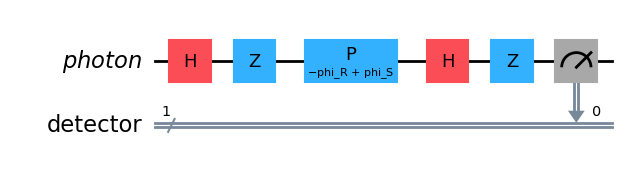

In [245]:
# Create a quantum register named "photon" and a classical bit
qr_photon = QuantumRegister(1, 'photon')
cr = ClassicalRegister(1, 'detector')

# Create a circuit with 1 qubit and 1 classical bit
qc = QuantumCircuit(qr_photon, cr)

# 1st BS; creates a superposition and a phase shift by π
qc.h(0)
qc.z(0)

# Phase shift by total of 2π due to the mirrors
# qc.p(pi*2,0)

# Phase shifts by (φ_S - φ_R) due to the lengths
qc.p(phi_S-phi_R,0)

# 2nd BS and a phase shift by π
qc.h(0)
qc.z(0)

# Measurement on qubit 0 (photon), projection on cbit 0 (detector)
qc.measure(0,0)

# Draw the circuit
qc.draw('mpl')

In [246]:
# Transpile the circuit
qc_trans = transpile(qc, backend)

RUN EXPERIMENTS

In [247]:
# Define # of shots for mitigation/qc runs
shots = 8192 # 2^13

In [253]:
# Define emtpy arrays that will store results for the experiments
mitigators = []
confusion_matrices = []
inv_confusion_matrices = []
unmitigated_counts = []

# Define a function for running a mitigation exp
def run_mitigation_exp():
    result = exp.run(backend, shots=shots).block_for_results()
    mitigator = result.analysis_results("Correlated Readout Mitigator").value
    mitigators.append(mitigator)
    confusion_matrices.append(mitigator.assignment_matrix())
    inv_confusion_matrices.append(mitigator.mitigation_matrix())

# Define a function for running a QC exp
def run_MZI_exp(bound_qc):
    job = backend.run(bound_qc, shots=shots)
    result = job.result()
    unmitigated_counts.append(result.get_counts())

# Assign phase shift values from 0 to 2π and run the mitigation & MZI experiments 33 times each with 8192 shots
for i in range(33):
    param_values = {phi_S: (pi/16)*i, phi_R: 0}
    bound_qc = qc_trans.assign_parameters(param_values)
    run_mitigation_exp()
    run_MZI_exp(bound_qc)

POST PROCESSING

In [254]:
# Define an empty array of unmitigated probabilities of each circuit w/ a param from 0 to 2π
unmitimitigated_probs = []
mitigated_probs = []
mitigaetd_quasi_probs = []
mitigated_counts = []

# Get unmitigated probabilities, mitigate probabilities, mitigated counts
for i in range(33):
    unmitimitigated_probs.append({label: count/shots for (label, count) in unmitigated_counts[i].items()})
    mitigated_quasi_prob = mitigators[i].quasi_probabilities(unmitigated_counts[i])
    mitigaetd_quasi_probs.append(mitigated_quasi_prob)
    mitigated_probs.append(mitigated_quasi_prob.nearest_probability_distribution().binary_probabilities())
    mitigated_counts.append({label: round(prob*shots) for (label, prob) in mitigated_probs[i].items()})

PRINT RESULT

Unmitigated Counts: 
{'0': 235, '1': 7957}
Mitigated Counts: 
{'1': 8192}


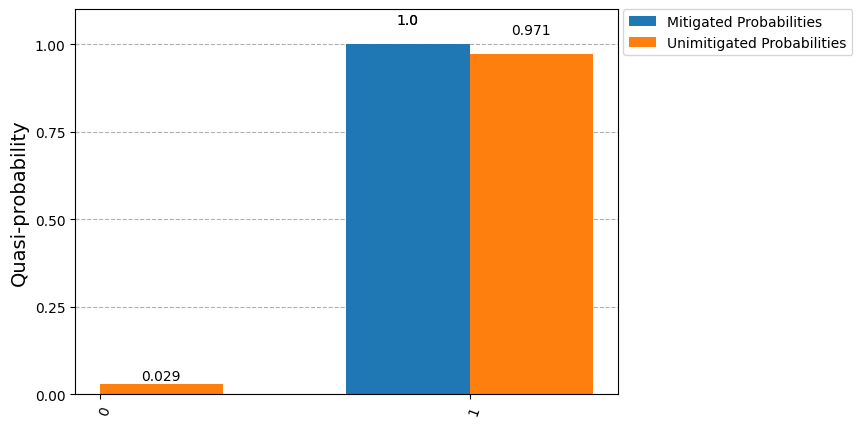

In [256]:
# Index of a circuit [0~32: 0=0π, 16=π, 32=2π]
i = 0

# Print unmitigated & mitigated counts and a probabilities plot
print("Unmitigated Counts: ")
print(unmitigated_counts[i]) 
print("Mitigated Counts: ")
print(mitigated_counts[i])
legend = ['Mitigated Probabilities','Unimitigated Probabilities']
plot_distribution([mitigated_probs[i], unmitimitigated_probs[i]], legend=legend)